<a href="https://colab.research.google.com/github/Kamruzzaman2200/Datamining/blob/main/Datamining_Cardio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install packages

In [ ]:
!pip -q install imbalanced-learn xgboost catboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


#Imports & global settings

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# sklearn & imblearn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# other
from scipy.stats import randint, uniform
import joblib

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment ready:", datetime.now())

Environment ready: 2025-11-14 20:24:37.232181


#Load dataset

In [ ]:
CSV_PATH = "/content/drive/MyDrive/Datasets/cardio_train.csv"

# Based on the error and the data preview, the CSV is delimited by semicolons.
# Explicitly specify sep=';' to correctly parse the file into multiple columns.
df = pd.read_csv(CSV_PATH, sep=';')

print("Raw shape:", df.shape)
display(df.head())

Raw shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#Basic cleaning: drop id, age→years, BMI

In [ ]:
# Drop id if exists
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Convert age (days -> years) if median > 1000
if 'age' not in df.columns:
    raise ValueError("Expected column 'age' not found in dataset.")
if df['age'].median() > 1000:
    df['age_years'] = (df['age'] / 365).round().astype(int)
else:
    df['age_years'] = df['age'].round().astype(int)

# BMI
if {'weight', 'height'}.issubset(df.columns):
    df['height_m'] = df['height'] / 100.0
    df.loc[df['height_m'] <= 0, 'height_m'] = df['height_m'].median()
    df['bmi'] = df['weight'] / (df['height_m'] ** 2)
    df.drop(columns=['height_m'], inplace=True)

# Confirm target exists
target_col = 'cardio'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found.")

print("After FE shape:", df.shape)
display(df.head())


After FE shape: (70000, 14)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


#Correlation filtering (drop highly correlated numeric features)

In [ ]:
CORR_THRESHOLD = 0.90

numeric_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_candidates:
    numeric_candidates.remove(target_col)

corr_matrix = df[numeric_candidates].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > CORR_THRESHOLD)]
print("Dropping due to high correlation (>|{:.2f}|):".format(CORR_THRESHOLD), to_drop)

df_reduced = df.drop(columns=to_drop)
print("Shape after drop:", df_reduced.shape)


Dropping due to high correlation (>|0.90|): ['age_years']
Shape after drop: (70000, 13)


#Recompute numeric and categorical lists

In [ ]:
# domain categorical
explicit_categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
explicit_categorical = [c for c in explicit_categorical if c in df_reduced.columns]

# numeric candidates excluding target
all_features = [c for c in df_reduced.columns if c != target_col]
numeric_cols = [c for c in all_features if pd.api.types.is_numeric_dtype(df_reduced[c])]
for c in explicit_categorical:
    if c in numeric_cols:
        numeric_cols.remove(c)

# ensure age_years and bmi in numeric
for n in ['age_years', 'bmi', 'ap_hi', 'ap_lo', 'weight', 'height']:
    if n in df_reduced.columns and n not in numeric_cols:
        numeric_cols.append(n)

# low-cardinality integers -> categorical-like
categorical_cols = explicit_categorical[:]
for c in numeric_cols[:]:
    if pd.api.types.is_integer_dtype(df_reduced[c]) and df_reduced[c].nunique() <= 10:
        categorical_cols.append(c)
        numeric_cols.remove(c)

numeric_cols = sorted(list(set(numeric_cols)))
categorical_cols = sorted(list(set(categorical_cols)))

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['age', 'ap_hi', 'ap_lo', 'bmi', 'height', 'weight']
Categorical cols: ['active', 'alco', 'cholesterol', 'gender', 'gluc', 'smoke']


#Tunable knobs: PCA & K_BEST

In [ ]:
USE_PCA = False       # Set True to enable PCA before SelectKBest
PCA_VARIANCE = 0.95
K_BEST = 10           # number of features to keep after SelectKBest

print("USE_PCA:", USE_PCA, "K_BEST:", K_BEST)


USE_PCA: False K_BEST: 10


#Build preprocessors and internal sklearn feature pipelines

In [ ]:
from sklearn.pipeline import make_pipeline

numeric_transformer_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_ohe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

categorical_transformer_ord = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

ohe_preprocessor_reduced = ColumnTransformer([
    ("num", numeric_transformer_scaled, numeric_cols),
    ("cat", categorical_transformer_ohe, categorical_cols)
], remainder="drop")

ord_preprocessor_reduced = ColumnTransformer([
    ("num", numeric_transformer_scaled, numeric_cols),
    ("cat", categorical_transformer_ord, categorical_cols)
], remainder="drop")

def make_feature_pipeline(preprocessor, use_pca=USE_PCA, pca_var=PCA_VARIANCE, k_best=K_BEST):
    steps = [("pre", preprocessor)]
    if use_pca:
        steps.append(("pca", PCA(n_components=pca_var, svd_solver="full", random_state=RANDOM_STATE)))
    steps.append(("varth", VarianceThreshold(threshold=0.0)))
    steps.append(("skb", SelectKBest(score_func=mutual_info_classif, k=min(k_best, 1000))))
    return Pipeline(steps=steps)

internal_ohe_pipeline = make_feature_pipeline(ohe_preprocessor_reduced)
internal_ord_pipeline = make_feature_pipeline(ord_preprocessor_reduced)

print("Internal feature pipelines created.")


Internal feature pipelines created.


#Wrapper class so imblearn accepts the pipeline as a single transformer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, clone

class FeaturePipelineWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def fit(self, X, y=None, **fit_params):
        self._pipeline = clone(self.pipeline)
        # pass y if the pipeline's fit supports it
        try:
            self._pipeline.fit(X, y)
        except TypeError:
            self._pipeline.fit(X)
        return self

    def transform(self, X):
        return self._pipeline.transform(X)

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)


#Create wrapped feature transformers and samplers

In [ ]:
fs_ohe_transformer = FeaturePipelineWrapper(internal_ohe_pipeline)
fs_ord_transformer = FeaturePipelineWrapper(internal_ord_pipeline)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
ros = RandomOverSampler(random_state=RANDOM_STATE)

print("Wrapped transformers and samplers ready.")


Wrapped transformers and samplers ready.


#Build model zoo using wrapped transformers (anti-overfitting defaults)

In [ ]:
models = {}

models["LogReg_FS_SMOTE"] = ImbPipeline(steps=[
    ("fs", fs_ohe_transformer),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=2000, penalty="l2", C=1.0, class_weight="balanced", random_state=RANDOM_STATE))
])

models["SVC_FS_SMOTE"] = ImbPipeline(steps=[
    ("fs", fs_ohe_transformer),
    ("smote", smote),
    ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", class_weight="balanced", random_state=RANDOM_STATE))
])

models["KNN_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ohe_transformer),
    ("ros", ros),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

models["DecisionTree_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ord_transformer),
    ("ros", ros),
    ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, random_state=RANDOM_STATE))
])

models["RandomForest_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ord_transformer),
    ("ros", ros),
    ("clf", RandomForestClassifier(n_estimators=150, max_depth=7, min_samples_leaf=10, max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1))
])

models["GB_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ord_transformer),
    ("ros", ros),
    ("clf", GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE))
])

models["XGB_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ord_transformer),
    ("ros", ros),
    ("clf", XGBClassifier(n_estimators=200, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, max_depth=3, reg_lambda=2.0, reg_alpha=0.5, eval_metric="logloss", random_state=RANDOM_STATE, tree_method="hist", n_jobs=-1))
])

models["CatBoost_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ord_transformer),
    ("ros", ros),
    ("clf", CatBoostClassifier(iterations=200, depth=4, learning_rate=0.05, l2_leaf_reg=3, loss_function="Logloss", verbose=False, random_seed=RANDOM_STATE))
])

models["Bagging_LogReg_FS_ROS"] = ImbPipeline(steps=[
    ("fs", fs_ohe_transformer),
    ("ros", ros),
    ("clf", BaggingClassifier(estimator=LogisticRegression(max_iter=2000, penalty="l2"), n_estimators=20, random_state=RANDOM_STATE, n_jobs=-1))
])

print("Model zoo ready with wrapped transformers.")


Model zoo ready with wrapped transformers.


#Train/test split (use df_reduced)

In [ ]:
X = df_reduced.drop(columns=[target_col])
y = df_reduced[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True).round(3))
print("Test target distribution:\n", y_test.value_counts(normalize=True).round(3))


Train shape: (52500, 12) Test shape: (17500, 12)
Train target distribution:
 cardio
0    0.5
1    0.5
Name: proportion, dtype: float64
Test target distribution:
 cardio
0    0.5
1    0.5
Name: proportion, dtype: float64


#CV scoring helpers (safe roc handling)

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
scoring = {"accuracy":"accuracy", "precision":"precision", "recall":"recall", "f1":"f1", "roc_auc":"roc_auc"}

def estimator_supports_roc_auc(pipeline):
    try:
        last = pipeline.steps[-1][1]
        return hasattr(last, "predict_proba") or hasattr(last, "decision_function")
    except Exception:
        return False

def evaluate_model(name, pipeline, X, y, cv=rskf, scoring=scoring):
    temp_scoring = scoring.copy()
    if not estimator_supports_roc_auc(pipeline):
        temp_scoring.pop("roc_auc", None)
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=temp_scoring, n_jobs=-1, return_train_score=False)
    summary = {metric: np.mean(cv_results[f"test_{metric}"]) for metric in temp_scoring.keys()}
    if "roc_auc" not in temp_scoring and "roc_auc" in scoring:
        summary["roc_auc"] = np.nan
    return summary


#Cross-validate all models (may take time)

In [ ]:
rows = []
for name, pipe in models.items():
    print(f"Evaluating {name} ...")
    try:
        res = evaluate_model(name, pipe, X_train, y_train)
    except Exception as e:
        print(f"Error evaluating {name}: {e}")
        res = {k: np.nan for k in scoring.keys()}
    row = {"Model": name}
    row.update({k.upper(): v for k, v in res.items()})
    rows.append(row)

results_cv = pd.DataFrame(rows).sort_values(by="ROC_AUC", ascending=False, na_position='last').reset_index(drop=True)
display(results_cv)
results_cv.to_csv("cv_results_baseline_fs.csv", index=False)


Evaluating LogReg_FS_SMOTE ...
Evaluating SVC_FS_SMOTE ...
Evaluating KNN_FS_ROS ...
Evaluating DecisionTree_FS_ROS ...
Evaluating RandomForest_FS_ROS ...
Evaluating GB_FS_ROS ...
Evaluating XGB_FS_ROS ...
Evaluating CatBoost_FS_ROS ...
Evaluating Bagging_LogReg_FS_ROS ...


,Model,ACCURACY,PRECISION,RECALL,F1,ROC_AUC
0,XGB_FS_ROS,0.736895,0.759302,0.693337,0.724782,0.803077
1,GB_FS_ROS,0.736190,0.754961,0.699042,0.725884,0.802834
2,CatBoost_FS_ROS,0.735886,0.755954,0.696323,0.724875,0.802705
3,RandomForest_FS_ROS,0.734298,0.765744,0.674888,0.717361,0.800746
4,DecisionTree_FS_ROS,0.732121,0.753857,0.689436,0.719974,0.794287
5,SVC_FS_SMOTE,0.731073,0.743098,0.705941,0.724013,0.789145
6,LogReg_FS_SMOTE,0.718483,0.737927,0.677352,0.706284,0.782376
7,Bagging_LogReg_FS_ROS,0.718343,0.737528,0.677708,0.706287,0.782170
8,KNN_FS_ROS,0.666806,0.673811,0.645956,0.659563,0.714095


#Short RandomizedSearchCV for RandomForest & SVC (to get tuned estimators)

In [ ]:
# RandomizedSearch for RandomForest (short)
rf_pipe = models["RandomForest_FS_ROS"]
rf_param_dist = {
 "clf__n_estimators": randint(100, 300),
 "clf__max_depth": randint(3, 10),
 "clf__min_samples_split": randint(2, 8),
 "clf__min_samples_leaf": randint(5, 20),
 "clf__max_features": ["sqrt", "log2"]
}

rf_rand = RandomizedSearchCV(rf_pipe, rf_param_dist, n_iter=12, scoring="roc_auc",
                            cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE),
                            random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

print("Fitting RF randomized search (short)...")
rf_rand.fit(X_train, y_train)
print("RF best score:", rf_rand.best_score_)

# RandomizedSearch for SVC (short)
svc_pipe = models["SVC_FS_SMOTE"]
svc_param_dist = {"clf__C": uniform(0.1, 5.0), "clf__gamma": uniform(0.001, 0.5)}
svc_rand = RandomizedSearchCV(svc_pipe, svc_param_dist, n_iter=12, scoring="roc_auc",
                             cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE),
                             random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

print("Fitting SVC randomized search (short)...")
svc_rand.fit(X_train, y_train)
print("SVC best score:", svc_rand.best_score_)


Fitting RF randomized search (short)...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
RF best score: 0.8020920667254231
Fitting SVC randomized search (short)...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
SVC best score: 0.7910910662745945


#Evaluate tuned models on test set (safe ROC handling)

In [ ]:
def evaluate_on_test(name, estimator, X_tr, y_tr, X_te, y_te):
    estimator.fit(X_tr, y_tr)
    proba = None
    if hasattr(estimator, "predict_proba"):
        try:
            proba = estimator.predict_proba(X_te)[:,1]
        except Exception:
            proba = None
    if proba is None and hasattr(estimator, "decision_function"):
        try:
            dec = estimator.decision_function(X_te)
            proba = dec if dec.ndim == 1 else dec[:,1]
        except Exception:
            proba = None
    pred = estimator.predict(X_te)
    metrics = {
     "Model": name,
     "Accuracy": accuracy_score(y_te, pred),
     "Precision": precision_score(y_te, pred),
     "Recall": recall_score(y_te, pred),
     "F1": f1_score(y_te, pred),
     "ROC_AUC": roc_auc_score(y_te, proba) if proba is not None else np.nan
    }
    return metrics, pred, proba

tuned_results = []

rf_best = rf_rand.best_estimator_
svc_best = svc_rand.best_estimator_
logreg_pipeline = models["LogReg_FS_SMOTE"]

for name, est in [("RF_Tuned", rf_best), ("SVC_Tuned", svc_best), ("LogReg_Default", logreg_pipeline)]:
    print("Evaluating on test:", name)
    try:
        m, pred, proba = evaluate_on_test(name, est, X_train, y_train, X_test, y_test)
    except Exception as e:
        print(f"Error evaluating {name} on test: {e}")
        m = {"Model": name, "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan, "ROC_AUC": np.nan}
    tuned_results.append(m)
    print(m)

test_results_df = pd.DataFrame(tuned_results).sort_values(by="ROC_AUC", ascending=False, na_position='last').reset_index(drop=True)
display(test_results_df)
test_results_df.to_csv("test_results_tuned_fs.csv", index=False)


Evaluating on test: RF_Tuned
{'Model': 'RF_Tuned', 'Accuracy': 0.7328, 'Precision': 0.7583492063492063, 'Recall': 0.682904516866781, 'F1': 0.7186522262334537, 'ROC_AUC': np.float64(0.7987073497819916)}
Evaluating on test: SVC_Tuned
{'Model': 'SVC_Tuned', 'Accuracy': 0.7273142857142857, 'Precision': 0.7413437006439072, 'Recall': 0.697770154373928, 'F1': 0.7188972667295005, 'ROC_AUC': np.float64(0.786222042848014)}
Evaluating on test: LogReg_Default
{'Model': 'LogReg_Default', 'Accuracy': 0.7126285714285714, 'Precision': 0.7323080770192548, 'Recall': 0.6697541452258433, 'F1': 0.6996356686376396, 'ROC_AUC': np.float64(0.7765710747987183)}


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RF_Tuned,0.732800,0.758349,0.682905,0.718652,0.798707
1,SVC_Tuned,0.727314,0.741344,0.697770,0.718897,0.786222
2,LogReg_Default,0.712629,0.732308,0.669754,0.699636,0.776571


#ROC curves for tuned models

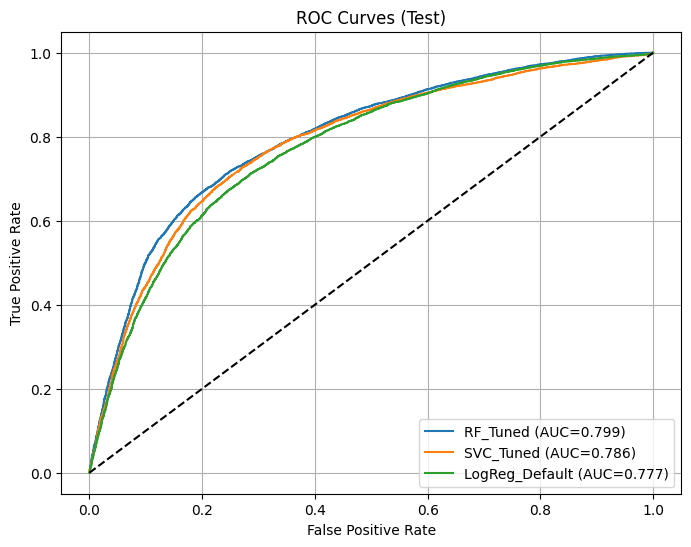

In [ ]:
plt.figure(figsize=(8,6))

def plot_roc_curve(estimator, name, X_te, y_te):
    proba = None
    if hasattr(estimator, "predict_proba"):
        try:
            proba = estimator.predict_proba(X_te)[:,1]
        except Exception:
            proba = None
    if proba is None and hasattr(estimator, "decision_function"):
        try:
            dec = estimator.decision_function(X_te)
            proba = dec if dec.ndim == 1 else dec[:,1]
        except Exception:
            proba = None
    if proba is None:
        print(f"No score for {name}; skipping ROC.")
        return
    fpr, tpr, _ = roc_curve(y_te, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plot_roc_curve(rf_best, "RF_Tuned", X_test, y_test)
plot_roc_curve(svc_best, "SVC_Tuned", X_test, y_test)
plot_roc_curve(logreg_pipeline, "LogReg_Default", X_test, y_test)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#Learning curve helper

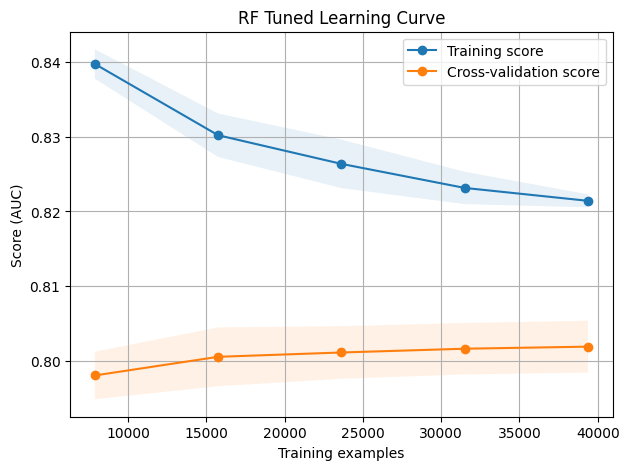

In [ ]:
def plot_learning_curve_for(title, estimator, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.2,1.0,5)):
    plt.figure(figsize=(7,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (AUC)")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc', shuffle=True, random_state=RANDOM_STATE)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve_for("RF Tuned Learning Curve", rf_best, X_train, y_train, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE))


#Build and evaluate a soft voting ensemble (if feasible)

In [ ]:
# Attempt to build a voting ensemble using the final estimators (without full pipelines).
def get_final_estimator(pipe):
    try:
        return pipe.steps[-1][1]
    except Exception:
        return pipe

try:
    rf_est = get_final_estimator(rf_best)
    svc_est = get_final_estimator(svc_best)
    lr_pipe = models["LogReg_FS_SMOTE"]
    lr_est = get_final_estimator(lr_pipe)

    # Create a VotingClassifier from underlying estimators
    voting = VotingClassifier(estimators=[("rf", rf_est), ("svc", svc_est), ("lr", lr_est)], voting="soft", n_jobs=-1)

    # Build pipeline that applies ord_preprocessor_reduced (to produce numeric array) before voting
    ensemble_pipeline = Pipeline([("pre", ord_preprocessor_reduced), ("clf", voting)])

    ensemble_pipeline.fit(X_train, y_train)
    if hasattr(ensemble_pipeline, "predict_proba"):
        proba = ensemble_pipeline.predict_proba(X_test)[:,1]
        print("Voting ensemble ROC_AUC:", roc_auc_score(y_test, proba))
    else:
        print("Ensemble does not expose predict_proba; ROC unavailable.")
except Exception as e:
    print("Could not build/evaluate ensemble:", e)


Voting ensemble ROC_AUC: 0.7944118642977517


#Save artifacts (CSV + pickled models)

In [ ]:
# Save results CSVs
results_cv.to_csv("cv_results_baseline_fs.csv", index=False)
test_results_df.to_csv("test_results_tuned_fs.csv", index=False)

# Pickle tuned estimators (they may include pipeline internals)
joblib.dump(rf_best, "rf_best_fs.pkl")
joblib.dump(svc_best, "svc_best_fs.pkl")
joblib.dump(logreg_pipeline, "logreg_pipeline_fs.pkl")

print("Saved CSVs and pickled tuned models.")


Saved CSVs and pickled tuned models.
